In [1]:
import linopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import linopy 
# import xarray as xr
import pyomo.environ as pyo
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from collections import Counter
import seaborn as sns
import csv
from datetime import datetime
import shapely
from shapely.geometry import Point
from shapely.ops import nearest_points

import geopandas as gpd
import contextily as ctx
import folium
from folium import FeatureGroup
from folium.plugins import MarkerCluster

import pandapower as pp

In [26]:
version=11

In [27]:
network = pp.from_json(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/modified_swiss_pdg/ppnetwork/369_0_ppnetwork.json')
network_geometry = [Point(xy) for xy in zip(network.bus_geodata.x,network.bus_geodata.y)]
network_gdf = gpd.GeoDataFrame(network.bus,geometry=network_geometry)
network_boundary = gpd.read_file(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/modified_swiss_pdg/boundary/369_0_boundary.geojson")

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.ob

In [2]:
mobility = pd.read_csv("/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/grid_206_mobility_dataset.csv")
mobility['dep_time'] = pd.to_datetime(mobility['dep_time'],format='mixed')
mobility['arr_time'] = pd.to_datetime(mobility['arr_time'],format='mixed')
mobility['dep_hour'] = mobility['dep_time'].dt.hour
mobility['arr_hour'] = mobility['arr_time'].dt.hour
inbound = mobility[ (mobility['grid']=="260_0") & (mobility['type_day']=="Friday")]

In [3]:
gpd.options.use_pygeos = True

inbound['arr_time'] = inbound['dep_time'] + pd.to_timedelta(inbound['trav_time'], unit='m')
inbound['arr_time'] = inbound['arr_time'].apply(lambda dt:dt.replace(day=1,month=5))
inbound = inbound[inbound['arr_time'].dt.day==1]
inbound['parking_time_hr'] = (inbound['parking_time']/60).astype('int')
inbound['park_end_time'] = inbound['arr_time']+pd.to_timedelta(mobility['parking_time'],unit='m')
inbound['park_end_hour'] = inbound['park_end_time'].dt.hour
inbound['park_end_day'] = inbound['park_end_time'].dt.day
inbound.head()
####################################################################################
## Dataframe here only contains next trip within this boundary, 
## next trips toward outside the boundary can not be considered here
# inbound.sort_values(by=['person','dep_time'])
# inbound['next_travel_TP1_consumption'] = inbound.groupby('person')['TP1 consumption kWh'].shift(-1).fillna(0)
# inbound['next_travel_dep_hour'] = inbound.groupby('person')['dep_hour'].shift(-1).fillna(0)
####################################################################################

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/geopandas/_config.py:104: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  compat.set_use_pygeos(value)


person            dep_time  trav_time  traveled_distance  \
886   1070561 2020-05-03 15:53:35  72.533333             85.166   
2017  1073337 2020-05-03 11:05:39  22.533333             30.416   
3349  1073839 2020-05-03 07:18:15  44.100000             48.901   
3527  1074175 2020-05-03 15:45:48   7.966667              4.429   
3615  1074243 2020-05-03 15:21:46  10.483333              6.083   

     start_activity_type end_activity_type    start_x    start_y      end_x  \
886                 home             other  2554601.0  1188275.0  2560312.0   
2017             leisure             other  2568802.0  1162552.0  2558752.0   
3349                home              work  2570629.0  1151948.0  2557446.0   
3527                work             other  2554140.0  1145703.0  2557372.0   
3615                work             other  2554140.0  1145703.0  2558292.0   

          end_y                      arr_time  parking_time  \
886   1148177.0 2020-05-01 17:06:06.999999998      2.466667   
2017  1144066.0 2020-05-01 11:28:10.999999998     67.466667   
3349  1143669.0 2020-05-01 08:02:21.000000000    165.900000   
3527  1144615.0 2020-05-01 15:53:46.000000002     27.033333   
3615  1143709.0 2020-05-01 15:32:14.999999998     24.516667   

      TP1 rate kWh/100 km  TP1 consumption kWh  TP2 rate kWh/100 km  \
886             28.213881            26.346272            26.474758   
2017            27.914971             9.174203            26.666602   
3349            28.264371            15.455814            25.659107   
3527            23.733482             1.196322            23.064483   
3615            24.763025             1.537833            23.903814   

      TP2 consumption kWh  TP3 rate kWh/100 km  TP3 consumption kWh  \
886             24.722270            24.760637            23.121615   
2017             8.763929            25.262522             8.302481   
3349            14.031177            25.232390            13.797835   
3527             1.162600            20.447605             1.030692   
3615             1.484474            21.005089             1.304458   

      TP4 rate kWh/100 km  TP4 consumption kWh    st_mun_name st_canton_name  \
886             24.279549            22.672372      Estavayer             FR   
2017            24.324729             7.994277        Vuadens             FR   
3349            23.382842            12.786446  Haut-Intyamon             FR   
3527            19.204887             0.968051          Vevey             VD   
3615            19.826204             1.231247          Vevey             VD   

     st_urb_type st_mnt_type            ed_mun_name ed_canton_name  \
886        Rural    Midlands  Blonay - Saint-Légier             VD   
2017       Urban        Alps               Montreux             VD   
3349       Rural        Alps               Montreux             VD   
3527       Urban    Midlands       La Tour-de-Peilz             VD   
3615       Urban    Midlands               Montreux             VD   

     ed_urb_type ed_mnt_type   Yearly kWh  id_node       name_node type_day  \
886        Urban        Alps  6227.595934     12.0  CH_Veytaux_220   Friday   
2017       Urban        Alps  2204.011403     12.0  CH_Veytaux_220   Friday   
3349       Urban        Alps  3607.889616     12.0  CH_Veytaux_220   Friday   
3527       Urban    Midlands   286.094506     12.0  CH_Veytaux_220   Friday   
3615       Urban        Alps   364.582854     12.0  CH_Veytaux_220   Friday   

                     geometry  index_right   grid  dep_hour  arr_hour  \
886   POINT (2560312 1148177)          0.0  260_0        15        17   
2017  POINT (2558752 1144066)          0.0  260_0        11        11   
3349  POINT (2557446 1143669)          0.0  260_0         7         8   
3527  POINT (2557372 1144615)          0.0  260_0        15        15   
3615  POINT (2558292 1143709)          0.0  260_0        15        15   

      parking_time_hr                 park_end_time  park_end_hour  \
886       

In [ ]:
'''
# Add nearest grid node location to the parking event
inbound_geometry = [Point(xy) for xy in zip(inbound.end_x, inbound.end_y)]
inbound_gdf = gpd.GeoDataFrame(inbound, geometry=inbound_geometry)
# Prepare a column in network_gdf with its index for reference
network_gdf['index_self'] = network_gdf.index
def find_nearest(row, df, return_dist=True):
    # Calculate all distances from row point to all points in the other dataframe
    distances = df.geometry.distance(row.geometry)
    # Find the minimum distance and the index of the closest point
    min_dist = distances.min()
    closest_point_index = distances.idxmin()
    if return_dist:
        return pd.Series([closest_point_index, min_dist], index=['nearest_node_index', 'distance'])
    else:
        return closest_point_index

# Apply the function to the inbound_gdf
inbound_gdf[['nearest_node_index', 'distance']] = inbound_gdf.apply(find_nearest, df=network_gdf, axis=1)
inbound_gdf['nearest_node_geometry'] = inbound_gdf['nearest_node_index'].apply(lambda x: network_gdf.loc[x].geometry)
'''

In [ ]:
'''
# Cluster all samples to 100 clusters then filter for the samples with the most frequent occuring 3-5 person ids
reduced_inbound = pd.DataFrame()
features = inbound[['trav_time', 'traveled_distance','start_x', 'start_y','end_x', 'end_y', 'parking_time', 'TP1 rate kWh/100 km','TP1 consumption kWh']]#, 'dep_hour', 'arr_hour','park_end_hour','park_end_day'
scaler = StandardScaler()
features_scaled= scaler.fit_transform(features)
k = 20 # number of clusters
clustering_kmeans = KMeans(k)
cluster_labels = clustering_kmeans.fit_predict(features_scaled)
inbound['cluster'] = cluster_labels # assign label to original sample

np.random.seed(42)
for cluster in inbound['cluster'].unique():
    cluster_data = inbound[inbound['cluster']==cluster]
    most_common_person_stats = Counter(cluster_data['person']).most_common(100)
    most_common_person = [stat[0] for stat in most_common_person_stats]
    reduced_cluster = cluster_data[cluster_data['person'].isin(most_common_person)]
    reduced_inbound = pd.concat([reduced_inbound, reduced_cluster])
reduced_inbound
'''

In [5]:
hourly_df = {} # dictionary contains parking event for each hour
hourly = pd.DataFrame() # parking event hourly data put together
date=1
reduced_inbound = inbound
# reduced_inbound = reduced_inbound.loc[reduced_inbound['parking_time']>=60]

for hour in range(24):
    hourly_df['hour'+str(hour)] = reduced_inbound.loc[((reduced_inbound.arr_hour<=hour) & (reduced_inbound.park_end_hour>=hour) & (reduced_inbound.park_end_day==date))|((reduced_inbound.park_end_day>date) & (reduced_inbound.arr_hour<=hour))]

    # Initialize parking minutes for each event within this hour
    hourly_df['hour'+str(hour)]['this_hour_parking_time']=0

    # Condition1: Parking spans the entire hour
    condition1 = ((hourly_df['hour'+str(hour)]['park_end_day']==date) & (hourly_df['hour'+str(hour)]['park_end_hour']>hour) & (hourly_df['hour'+str(hour)]['arr_hour']<hour)) | ((hourly_df['hour'+str(hour)]['park_end_day']>date) & (hourly_df['hour'+str(hour)]['arr_hour']<hour))
    hourly_df['hour'+str(hour)].loc[condition1, 'this_hour_parking_time'] = 60

    # Condition2: Arrival within the hour and parking ends after this hour
    condition2 = ((hourly_df['hour'+str(hour)]['park_end_day']==date) & (hourly_df['hour'+str(hour)]['park_end_hour']>hour) & (hourly_df['hour'+str(hour)]['arr_hour']==hour)) | ((hourly_df['hour'+str(hour)]['park_end_day']>date) & (hourly_df['hour'+str(hour)]['arr_hour']==hour))
    hourly_df['hour'+str(hour)].loc[condition2, 'this_hour_parking_time'] = 60-hourly_df['hour'+str(hour)].loc[condition2,'arr_time'].dt.minute

    # Condition3: Arrival before this hour and parking ends within this hour
    condition3 = (hourly_df['hour'+str(hour)]['park_end_hour']==hour) & (hourly_df['hour'+str(hour)]['arr_hour']<hour) & (hourly_df['hour'+str(hour)]['park_end_day']==date)
    hourly_df['hour'+str(hour)].loc[condition3, 'this_hour_parking_time']  = hourly_df['hour'+str(hour)].loc[condition3,'park_end_time'].dt.minute

    # Condition4: Arrival and parking ends within this hour
    condition4 = (hourly_df['hour'+str(hour)]['park_end_hour']==hour) & (hourly_df['hour'+str(hour)]['park_end_day']==date) & (hourly_df['hour'+str(hour)]['arr_hour']==hour)
    hourly_df['hour'+str(hour)].loc[condition4, 'this_hour_parking_time'] = hourly_df['hour'+str(hour)].loc[condition4,'park_end_time'].dt.minute-hourly_df['hour'+str(hour)].loc[condition4,'arr_time'].dt.minute

    hourly_df['hour'+str(hour)]['hour_of_day'] = hour
    #hourly_df['hour'+str(hour)].index = range(len(hourly_df['hour'+str(hour)]))


    hourly = pd.concat([hourly,hourly_df['hour'+str(hour)]])

hourly

person            dep_time  trav_time  traveled_distance  \
484817   6408856 2020-05-03 23:44:03  32.300000             30.177   
484886   6408861 2020-05-03 23:31:05  34.866667             40.990   
502483   6410782 2020-05-03 23:40:10  26.733333             11.179   
504817   6411079 2020-05-03 23:58:52   9.566667              5.862   
505173   6411115 2020-05-03 23:35:09  36.133333             30.400   
...          ...                 ...        ...                ...   
1498133  7133374 2020-05-03 17:41:50  40.233333             25.340   
1499526  7134427 2020-05-03 14:25:24  38.800000             44.157   
1499564  7134444 2020-05-03 09:34:57   3.416667              0.995   
1499585  7134445 2020-05-03 15:59:03  16.200000              8.379   
1499818  7134587 2020-05-03 10:40:00   1.683333              1.361   

        start_activity_type end_activity_type    start_x    start_y  \
484817              leisure              home  2535262.0  1153808.0   
484886              leisure              home  2572774.0  1157213.0   
502483              leisure              home  2561528.0  1142327.0   
504817              leisure              home  2560702.0  1140445.0   
505173              leisure              home  2568430.0  1130387.0   
...                     ...               ...        ...        ...   
1498133               other              home  2551620.0  1159469.0   
1499526                shop              home  2550634.0  1168057.0   
1499564               other              home  2558580.0  1143452.0   
1499585                shop              home  2561352.0  1137950.0   
1499818                shop              home  2556254.0  1144381.0   

             end_x      end_y                      arr_time  parking_time  \
484817   2558766.0  1146228.0 2020-05-01 00:16:21.000000000    927.700000   
484886   2558145.0  1146044.0 2020-05-01 00:05:57.000000002    925.116667   
502483   2557789.0  1143632.0 2020-05-01 00:06:53.999999998    898.266667   
504817   2558227.0  1143903.0 2020-05-01 00:08:26.000000002    930.416667   
505173   2557885.0  1144499.0 2020-05-01 00:11:16.999999998    923.866667   
...            ...        ...                           ...           ...   
1498133  2558303.0  1146131.0 2020-05-01 18:22:03.999999998    639.766667   
1499526  2558201.0  1143767.0 2020-05-01 15:04:12.000000000   1041.200000   
1499564  2558167.0  1143495.0 2020-05-01 09:38:22.000000002   1361.566667   
1499585  2558167.0  1143495.0 2020-05-01 16:15:15.000000000    523.083333   
1499818  2557026.0  1143764.0 2020-05-01 10:41:40.999999998   1318.316667   

         TP1 rate kWh/100 km  TP1 consumption kWh  TP2 rate kWh/100 km  \
484817             24.892851             8.111284            26.345385   
484886             29.215255            13.080525            26.742926   
502483             26.849249             3.527282            28.731934   
504817             23.687052             1.460451            25.090633   
505173             24.232199             8.244593            25.737699   
...                      ...                  ...                  ...   
1498133            24.556426             6.763486            22.459139   
1499526            27.497627            13.358513            26.477587   
1499564            32.211922             0.283611            32.154570   
1499585            25.376122             2.293387            24.422000   
1499818            26.745969             0.144878            26.517800   

         TP2 consumption kWh  TP3 rate kWh/100 km  TP3 consumption kWh  \
484817              8.584589            24.108032             7.855552   
484886             11.973591            27.244801            12.198295   
502483              3.774617            25.662506             3.371376   
504817              1.546990            22.888033             1.411187   
505173              8.756814            23.444514             7.976596   
...                      ...                  ...         

In [6]:
for t in range(24):
    print(len(hourly_df[f'hour{t}']))

53
106
159
194
215
417
1085
2107
2957
3544
4125
4675
5013
5185
5420
5788
6374
7122
7253
7252
7068
7012
7097
7030


In [44]:
# Prepare profile to be matched
tomatch = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/HV_uncontrolled_load_hourly_2050.csv")
tomatch.rename(columns={'Unnamed: 0':'ts'}, inplace=True)
tomatch = tomatch.loc[(tomatch.ts<"2050-05-07 00:00:00") & (tomatch.ts>="2050-05-06 00:00:00")][['ts','peak','12']]
day_max = tomatch['12'].max()
day_min = tomatch['12'].min()

tomatch['scaled_12_kwh']=(tomatch['12']-day_min)/(day_max-day_min)
tomatch.index=range(1,25)
tomatch

ts  peak        12  scaled_12_kwh
1   2050-05-06 00:00:00     0  1.696930       0.756485
2   2050-05-06 01:00:00     0  1.374024       0.607046
3   2050-05-06 02:00:00     0  0.900958       0.388115
4   2050-05-06 03:00:00     0  0.569268       0.234611
5   2050-05-06 04:00:00     0  0.353022       0.134533
6   2050-05-06 05:00:00     0  0.217083       0.071622
7   2050-05-06 06:00:00     0  0.130501       0.031552
8   2050-05-06 07:00:00     0  0.079472       0.007937
9   2050-05-06 08:00:00     1  0.062323       0.000000
10  2050-05-06 09:00:00     1  0.063159       0.000387
11  2050-05-06 10:00:00     1  0.091602       0.013550
12  2050-05-06 11:00:00     1  0.175256       0.052265
13  2050-05-06 12:00:00     1  0.280242       0.100852
14  2050-05-06 13:00:00     1  0.324161       0.121177
15  2050-05-06 14:00:00     1  0.338382       0.127758
16  2050-05-06 15:00:00     1  0.439604       0.174603
17  2050-05-06 16:00:00     1  0.660870       0.277003
18  2050-05-06 17:00:00     1  1.178273       0.516454
19  2050-05-06 18:00:00     1  1.896028       0.848626
20  2050-05-06 19:00:00     1  2.223117       1.000000
21  2050-05-06 20:00:00     1  2.078813       0.933217
22  2050-05-06 21:00:00     0  1.863821       0.833720
23  2050-05-06 22:00:00     0  1.736248       0.774681
24  2050-05-06 23:00:00     0  1.593617       0.708672

In [33]:
#######################################################################################
#            Optimize aggregated demand profile to fit nexus output                   #
#######################################################################################
m = pyo.AbstractModel()
charge_decision_memory = {}

############################
# Set
m.E = pyo.Set() # parking event set

############################
# Decision Variable
m.charge_decision = pyo.Var(m.E, within=pyo.Binary, initialize=0)
#m.charge_power = pyo.Var(m.E, within=pyo.NonNegativeReals, initialize=11)

###########################
# Parameters
m.load_to_match = pyo.Param() 
m.hour_of_day = pyo.Param()
m.max_power = pyo.Param(m.E, initialize=11) # unit kW
m.charge_minutes = pyo.Param(m.E, initialize=0) # parking minutes within this hour
m.distance = pyo.Param(m.E, initialize=0) # distance from parking point to load point
m.arr_hour = pyo.Param(m.E, initialize=0)
m.park_end_hour = pyo.Param(m.E, initialize=0)

def get_charge_status_memory(m,e):
    return charge_decision_memory.get(e,0)
m.previous_charge_decision = pyo.Param(m.E, within=pyo.Binary, mutable=True, initialize=get_charge_status_memory) # charge_decision memory

############################
# Constraints

# def max_power_rule(m,e):
#     return m.charge_power[e]<=m.max_power[e]
# m.max_power_constr = pyo.Constraint(m.E, rule=max_power_rule)


# force charge_decision to 0 when charge_minutes < 10
def no_charge_short_stay_rule(m, e):
    # If charge_minutes for EV 'e' is less than 10, then charge_decision must be 0
    if (m.charge_minutes[e]<15) & ((m.park_end_hour[e]==m.hour_of_day) | (m.arr_hour[e]==m.hour_of_day)):
        return m.charge_decision[e]==0
    else:
        return pyo.Constraint.Skip
m.no_charge_short_stay = pyo.Constraint(m.E, rule=no_charge_short_stay_rule)

def load_point_too_far_rule(m,e):
    if m.distance[e]>30:
        return  m.charge_decision[e]==0
    else:
        return pyo.Constraint.Skip
m.load_point_to_far = pyo.Constraint(m.E, rule=load_point_too_far_rule)

############################
# Expressions

def charge_demand_t_rule(m):
    return sum(m.charge_decision[e] * m.max_power[e] * (m.charge_minutes[e]/60) for e in m.E) # Sum up demand at each hour for all EVs
m.charge_demand_t = pyo.Expression(rule=charge_demand_t_rule)

###########################
# Objective 
def objective_rule(m):
    return ((m.load_to_match-m.charge_demand_t)**2 - sum(m.previous_charge_decision[e]*m.charge_decision[e] for e in m.E))
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)


###########################
# Solve abstract model

for t in range(0,24):
    tomatch_t = tomatch['scaled_12_kwh'][t+1]
    events_t = hourly_df['hour'+str(t)]
    data_t = {None:{
        'E': {None:list(events_t.index)},
        'charge_minutes':{e:events_t.loc[e,'this_hour_parking_time'] for e in events_t.index},
        'arr_hour':{e:events_t.loc[e,'arr_hour'] for e in events_t.index},
        'park_end_hour':{e:events_t.loc[e,'park_end_hour'] for e in events_t.index},
        'distance':{e:events_t.loc[e,'distance'] for e in events_t.index},
        'load_to_match':{None:tomatch_t},
        'hour_of_day':{None:t}
    }}
    instance_t = m.create_instance(data=data_t)
    #instance_t.pprint()
    solver = pyo.SolverFactory('gurobi')
    solver.solve(instance_t)
    
    # update charge_decision_memory dictionary,keep only the memory where the vehicle also include in current hour set
    current_hour_event = set(instance_t.E)
    keys_to_remove = [e for e in charge_decision_memory if e not in current_hour_event]
    for e in keys_to_remove:
        del charge_decision_memory[e]
    for e in current_hour_event:
        charge_decision_memory[e] = instance_t.charge_decision[e].value # assign last charge decision to the memory dictionary

    # save optimization result to csv files
    decision_variables_hour_t={}
    for v in instance_t.component_objects(pyo.Var, active=True):
        print(f"Variable{v}:")
        var_object = getattr(instance_t,str(v))
        for index in var_object:
            variable_value=var_object[index].value
            print(f"  Index {index}: {variable_value}")
            decision_variables_hour_t[(str(v), index)] = variable_value            
    with open(f'version_{version}/decision_variables_hour_{t}_v{version}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Variable Name', 'Index', 'Value'])
        for (var_name, index), value in decision_variables_hour_t.items():
            writer.writerow([var_name, index, value])

Variablecharge_decision:
  Index 484817: 0.0
  Index 484886: 1.0
  Index 502483: 0.0
  Index 504817: -0.0
  Index 505173: -0.0
  Index 510454: 0.0
  Index 512076: -0.0
  Index 513690: 0.0
  Index 697113: 0.0
  Index 697409: 0.0
  Index 721654: -0.0
  Index 737864: -0.0
  Index 738149: -0.0
  Index 739012: 0.0
  Index 752261: -0.0
  Index 775305: -0.0
  Index 850587: -0.0
  Index 860717: -0.0
  Index 871598: -0.0
  Index 898747: -0.0
  Index 908770: -0.0
  Index 1062911: 0.0
  Index 1065397: -0.0
  Index 1069332: 0.0
  Index 1069735: 0.0
  Index 1074606: -0.0
  Index 1078489: -0.0
  Index 1079819: 0.0
  Index 1105560: -0.0
  Index 1109988: -0.0
  Index 1111562: 0.0
  Index 1114410: -0.0
  Index 1116616: -0.0
  Index 1119335: 0.0
  Index 1120079: -0.0
  Index 1137987: -0.0
  Index 1139116: 0.0
  Index 1140684: 0.0
  Index 1143514: 0.0
  Index 1144429: -0.0
  Index 1146155: -0.0
  Index 1147082: 0.0
  Index 1151031: -0.0
  Index 1159188: -0.0
  Index 1260084: -0.0
  Index 1265838: -0.0
  

In [34]:
#################################################################################################
#               Intermediate Step for saving demand profile from optimization                   #
#################################################################################################
profile_res = pd.DataFrame()
for t in range(24):
    opt_res = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/version_{version}/decision_variables_hour_{t}_v{version}.csv")
    index_list = (list(opt_res[opt_res.Value==1.0].Index))
    profile_t = hourly_df[f'hour{t}'].loc[index_list]
    profile_t['this_charge_hour']=t
    profile_res = pd.concat([profile_res,profile_t])
profile_res.to_csv(f"version_{version}/opt_profile_res_v{version}.csv")

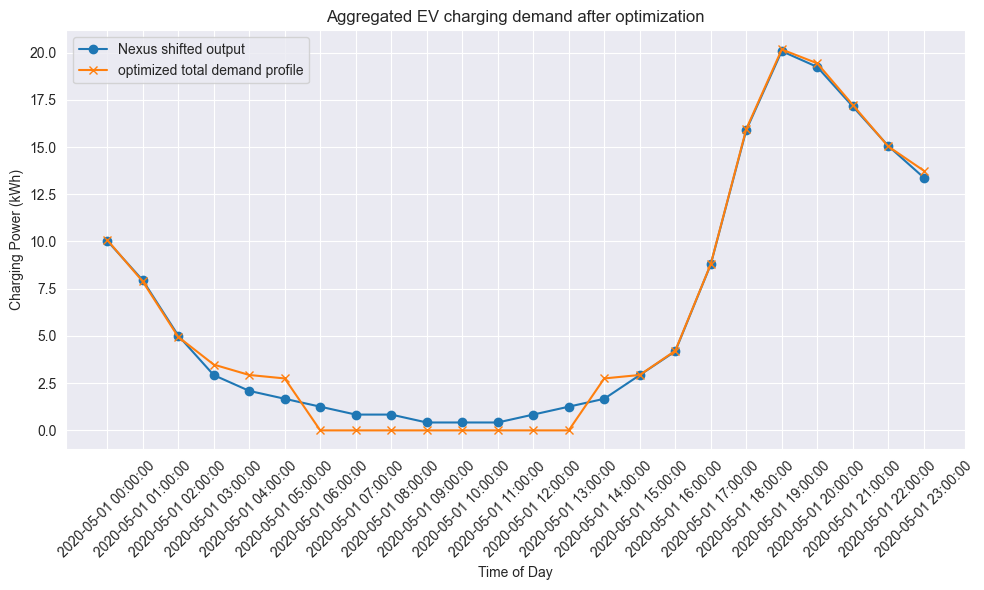

In [35]:
#################################################################################################
#    Compare aggregated demand profile from optimization with nexus e output                    #
#################################################################################################
profile_res = pd.read_csv(f"version_{version}/opt_profile_res_v{version}.csv")
profile_res['charge_energy'] = (profile_res['this_hour_parking_time']*float(11/60)).astype('float')
opt_agg_hourly_dmd = profile_res.groupby(['this_charge_hour']).agg(aggregated_charge_energy=('charge_energy', 'sum'))
opt_agg_hourly_dmd = opt_agg_hourly_dmd.reindex(range(24)).fillna(0.0).reset_index()
opt_agg_hourly_dmd
plt.figure(figsize=(10,6))
plt.plot(tomatch['ts'],tomatch['scaled_12_kwh'],label="Nexus shifted output", marker = "o")
plt.plot(tomatch['ts'], opt_agg_hourly_dmd['aggregated_charge_energy'], label="optimized total demand profile",marker='x')
plt.xlabel('Time of Day')
plt.ylabel('Charging Power (kWh)')
plt.title('Aggregated EV charging demand after optimization')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"version_{version}/Optimization_result_agg_demand_v{version}.png")
plt.show()

In [36]:
################################################################
# Create Charge Profile for each EV with a single row          #
################################################################
profile_res = pd.read_csv(f"version_{version}/opt_profile_res_v{version}.csv")
profile = profile_res.groupby('person').agg(charge_start_hour=('this_charge_hour','min'),charge_end_hour=('this_charge_hour','max'),arr_time=('arr_time','first'),arr_hour=('arr_hour','first'),park_end_time=('park_end_time','first'),park_end_hour=('park_end_hour','first'),charge_minute=('this_hour_parking_time', 'sum'),end_x=('end_x','first'), end_y=('end_y','first'))
profile = profile.merge(profile_res[['person','this_charge_hour','this_hour_parking_time']], how='left', left_on=['person','charge_start_hour'],right_on=['person','this_charge_hour']).drop(['this_charge_hour'],axis=1)\
        .rename(columns={'this_hour_parking_time':'start_hour_charge_time'})\
        .merge(profile_res[['person','this_charge_hour','this_hour_parking_time']], how='left', left_on=['person','charge_end_hour'],right_on=['person','this_charge_hour']).drop(['this_charge_hour'],axis=1)\
        .rename(columns={'this_hour_parking_time':'end_hour_charge_time'})
def charge_start_time(EV_profile):
    if EV_profile['charge_start_hour']==EV_profile['arr_hour']:
        charge_start_ts = EV_profile['arr_time']
    elif EV_profile['charge_start_hour']>EV_profile['arr_hour']:
        charge_start_ts = datetime(year=2020, month=5,day=1,hour=EV_profile['charge_start_hour'])
    charge_start_ts = pd.to_datetime(charge_start_ts, format='mixed')
    return charge_start_ts
profile['charge_start_time'] = profile.apply(charge_start_time,axis=1)
profile['charge_end_time'] = profile['charge_start_time'] + pd.to_timedelta(profile['charge_minute'], unit='m')
profile.to_csv(f"version_{version}/profile_per_person_v{version}.csv")

In [37]:
network_gdf=network_gdf.set_crs("epsg:2056") 
network_boundary = network_boundary.set_crs("epsg:2056")
network_gdf = network_gdf.to_crs('epsg:4326')
network_boundary = network_boundary.to_crs('epsg:4326')
profile = pd.read_csv(f"version_{version}/profile_per_person_v{version}.csv")
geometry = [Point(xy) for xy in zip(profile['end_x'],profile['end_y'])]
profile_gdf = gpd.GeoDataFrame(profile,geometry=geometry,crs="epsg:2056")
profile_gdf = profile_gdf.to_crs('epsg:4326')

# initialize the interactive map
m = folium.Map(location=[profile_gdf.geometry.y.mean(), profile_gdf.geometry.x.mean()], zoom_start=12)
# add boundary plot on map
folium.GeoJson(
    network_boundary,
    name='area_boundary',
    style_function=lambda feature:{
            'fillColor':'red',
            'color':'red',#FFC0CB
            'weight':2,
            'dashArray':'5, 5',
            'fillOpacity':0.3
        }
    ).add_to(m)

# add sysnthetic grid node position
synthetic_grid_nodes = FeatureGroup(name='Synthetic Grid Nodes', show=True)
for _,row in network_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y,row.geometry.x],
        radius=2,
        color='green' if row.vn_kv==0.4 else 'purple',
        fill=True,
        fill_color='green' if row.vn_kv==0.4 else 'purple',
        popup=row[['name','zone','geometry']]
    ).add_to(synthetic_grid_nodes)
synthetic_grid_nodes.add_to(m)
    
# add parking/charging event on map
for _, row in profile_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row[['person','geometry','arr_time','park_end_time','charge_start_time','charge_end_time']]  # Pop up information 
    ).add_to(m)
    
folium.LayerControl().add_to(m)
m.save(f'version_{version}/charging_point_interactive_map_v{version}.html')
m


In [38]:
profile['charge_start_time'] = pd.to_datetime(profile['charge_start_time'],format='mixed')
profile['charge_end_time'] = pd.to_datetime(profile['charge_end_time'],format='mixed')
profile

Unnamed: 0   person  charge_start_hour  charge_end_hour  \
0            0  1097281                 15               15   
1            1  1193544                 17               20   
2            2  3935542                 16               16   
3            3  6324025                  5                5   
4            4  6408861                  0                0   
5            5  6408907                 22               23   
6            6  6411408                  1                1   
7            7  6413049                 14               14   
8            8  6413361                 19               22   
9            9  6413700                 20               20   
10          10  6413900                 18               18   
11          11  6476740                  4                4   
12          12  6578215                  3                3   
13          13  6932268                 21               21   
14          14  7020838                 23               23   
15          15  7080718                  2                2   

                         arr_time  arr_hour                  park_end_time  \
0   2020-05-01 15:44:47.000000000        15  2020-05-01 22:24:05.000000000   
1   2020-05-01 17:12:01.999999998        17  2020-05-01 20:31:21.000000018   
2   2020-05-01 06:14:49.000000000         6  2020-05-01 16:23:43.000000000   
3   2020-05-01 05:45:22.999999998         5  2020-05-01 17:31:12.000000018   
4   2020-05-01 00:05:57.000000002         0  2020-05-01 15:31:04.000000004   
5   2020-05-01 22:38:41.000000002        22  2020-05-02 15:06:54.000000004   
6   2020-05-01 01:17:50.999999998         1  2020-05-01 20:10:13.000000000   
7   2020-05-01 14:45:15.000000000        14  2020-05-01 16:36:51.000000000   
8   2020-05-01 19:10:49.000000000        19  2020-05-04 07:28:49.000000000   
9   2020-05-01 20:45:19.000000000        20  2020-05-02 09:13:34.000000000   
10  2020-05-01 17:12:52.000000002        17  2020-05-01 18:27:08.999999982   
11  2020-05-01 04:44:13.000000000         4  2020-05-01 15:35:46.000000000   
12  2020-05-01 03:41:11.999999998         3  2020-05-01 16:18:13.000000000   
13  2020-05-01 21:26:34.999999998        21  2020-05-02 15:33:39.000000000   
14  2020-05-01 23:45:08.000000002        23  2020-05-02 08:03:06.000000004   
15  2020-05-01 02:33:25.000000002         2  2020-05-01 14:25:44.000000004   

    park_end_hour  charge_minute      end_x      end_y  \
0              22             16  2558068.0  1144790.0   
1              20            199  2557876.0  1144980.0   
2              16             23  2557890.0  1143480.0   
3              17             15  2558290.0  1143624.0   
4              15             55  2558145.0  1146044.0   
5              15             82  2558431.0  1145938.0   
6              20             43  2557496.0  1143717.0   
7              16             15  2557971.0  1144743.0   
8               7            230  2559244.0  1143821.0   
9               9             15  2557840.0  1143619.0   
10             18             27  2558246.0  1143811.0   
11             15             16  2558912.0  1143705.0   
12             16             19  2557497.0  1143772.0   
13             15             34  2560808.0  1147272.0   
14              8             15  2558514.0  1145999.0   
15             14             27  2556857.0  1144887.0   

    start_hour_charge_time  end_hour_charge_time  \
0                       16                    16   
1                       48                    31   
2                       23                    23   
3                       15                    15   
4                       55                    55   
5                       22                    60   
6                       43                    43   
7                       15                    15   
8                       50                    60   
9                       15                    15   
10                      27                    

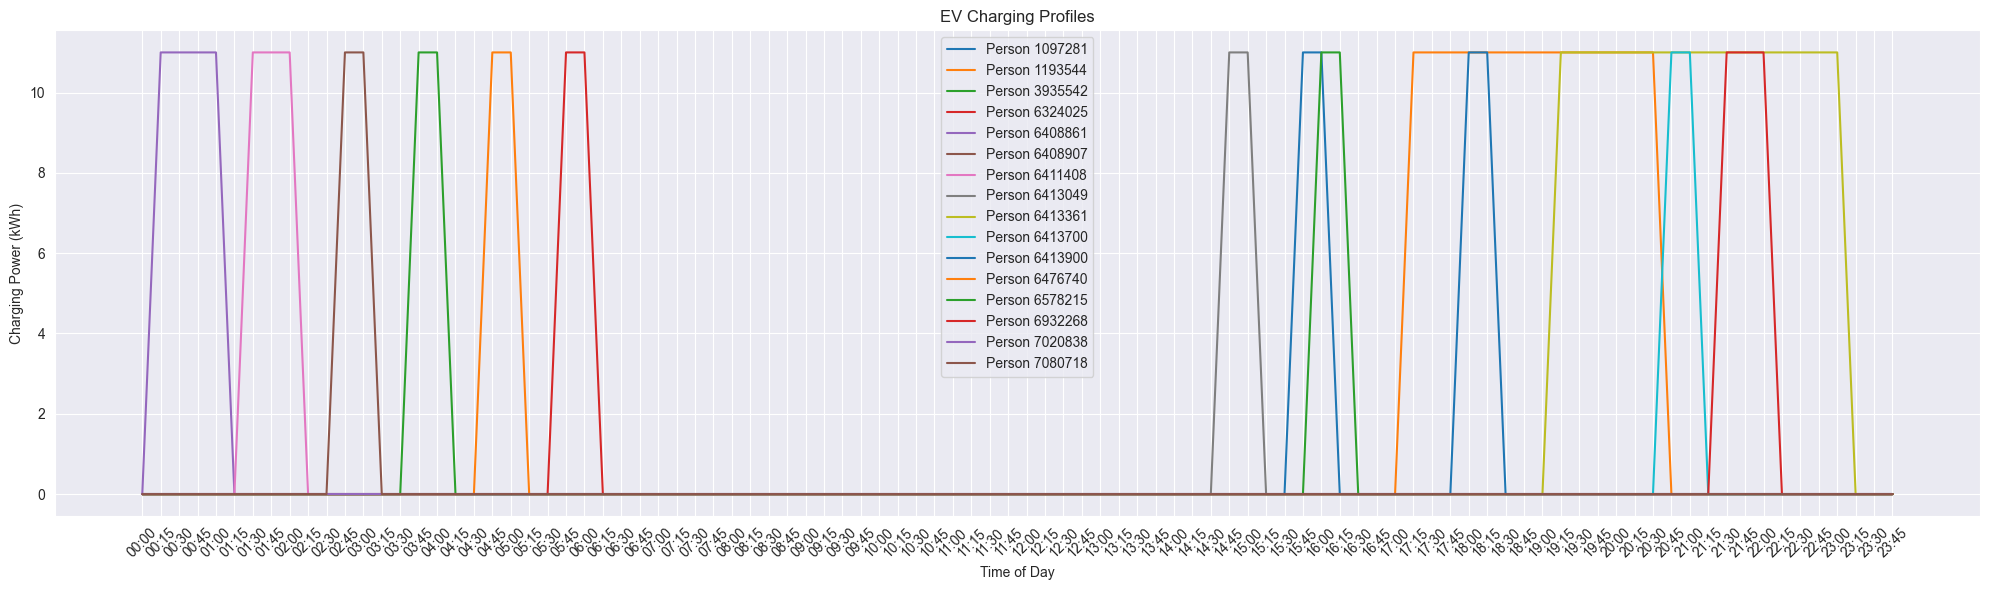

In [39]:
####################################################################
#                   Plot Single EV Charge Profile                  #
####################################################################

#Discretize the 24-hour day into 15-minute intervals
time_range = pd.date_range('2020-05-01', '2020-05-02', freq='15min')[:-1]
time_labels = time_range.strftime('%H:%M')

# Initialize a DataFrame to hold the charging profiles
charging_profiles = pd.DataFrame(0, index=profile['person'], columns=time_labels)

# Populate the charging profiles
for i, row in profile.iterrows():
    start_label = row['charge_start_time'].strftime('%H:%M')
    end_label = row['charge_end_time'].strftime('%H:%M')
    charging_profiles.loc[row['person'], start_label:end_label] = 11  # 11 kWh charging power

# Plot the profiles
plt.figure(figsize=(20, 6))

for index, row in charging_profiles.iterrows():
    plt.plot(time_labels, row, label=f'Person {index}')

plt.xlabel('Time of Day')
plt.ylabel('Charging Power (kWh)')
plt.title('EV Charging Profiles')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"version_{version}/charging_profile_per_person_v{version}.png")
plt.show()


In [ ]:
################################################################
################################################################
################################################################

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_91709/1354578567.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['cluster'] = cluster_labels # assign label to original sample


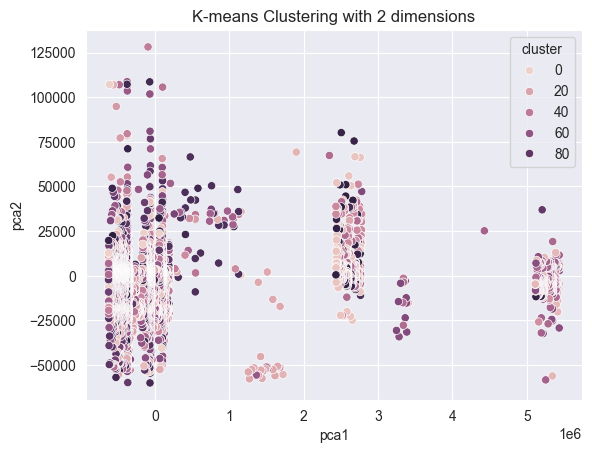

Explained variation per principal component: [9.99791611e-01 1.07749199e-04]
Cumulative variance explained by principal components: 99.99%


         person  trav_time  traveled_distance   start_x   start_y     end_x  \
PC_1  0.999999   0.000003           0.000003  0.001151  0.000054  0.000031   
PC_2  0.001122   0.000164           0.000077  0.983103  0.182908  0.000131   

         end_y  parking_time  TP1 rate kWh/100 km  TP1 consumption kWh  \
PC_1  0.000042      0.000047         7.042372e-08             0.000001   
PC_2  0.007184      0.000530         2.518446e-05             0.000009   

          dep_hour      arr_hour  next_travel_TP1_consumption   cluster  
PC_1  6.308973e-07  5.715490e-07                 5.359807e-08  0.000002  
PC_2  3.032728e-05  3.385482e-05                 5.118805e-06  0.000169  

*************** Most important features *************************
As per PC 1:
 person                         9.999993e-01
trav_time                      2.839067e-06
traveled_

person  trav_time  traveled_distance       start_x       start_y  \
1    6.725632e+06  10.365647           3.404986  2.558938e+06  1.143875e+06   
2    6.731705e+06   7.829976           4.515490  2.557433e+06  1.144309e+06   
3    6.726208e+06  31.803989          29.665974  2.562165e+06  1.128844e+06   
4    6.688862e+06   8.025071           4.232328  2.557443e+06  1.144297e+06   
5    6.755490e+06  31.437904          28.461526  2.539459e+06  1.154195e+06   
..            ...        ...                ...           ...           ...   
96   6.797546e+06  11.369582           5.756050  2.556811e+06  1.144699e+06   
97   3.168845e+06  30.979687          27.339937  2.559223e+06  1.139505e+06   
98   4.289648e+06  76.475694          98.512833  2.609090e+06  1.123097e+06   
99   6.709952e+06   6.815333           3.670167  2.557744e+06  1.144096e+06   
100  6.735064e+06   8.678663           4.650218  2.557000e+06  1.144692e+06   

            end_x         end_y  parking_time  TP1 rate kWh/100 km  \
1    2.559253e+06  1.144124e+06    194.555755            30.293187   
2    2.558113e+06  1.143747e+06     76.444374            25.443739   
3    2.558253e+06  1.144388e+06   1114.012963            26.031857   
4    2.558219e+06  1.144939e+06    161.607407            25.745065   
5    2.557957e+06  1.143940e+06    769.450970            25.986951   
..            ...           ...           ...                  ...   
96   2.558224e+06  1.145920e+06    937.579057            26.690630   
97   2.557868e+06  1.144606e+06    300.511979            26.498634   
98   2.558320e+06  1.144353e+06    260.686111            28.767741   
99   2.558027e+06  1.143612e+06    132.869741            25.343237   
100  2.557181e+06  1.144234e+06    262.937758            25.653585   

     TP1 consumption kWh   dep_hour   arr_hour  next_travel_TP1_consumption  
1               1.167093   8.302158   8.507194                 8.871794e-01  
2               1.243171  16.693285  16.838475                 5.556837e-01  
3               8.413566  15.111111  15.307692                -1.110223e-16  
4               1.202622   7.829060   7.940171                 5.405762e-01  
5               8.118414  18.166205  18.673130                 5.145762e-04  
..                   ...        ...        ...                          ...  
96              1.707588  16.696793  16.860058                 2.513247e-03  
97              8.016057   7.000000   7.437500                 7.585192e+00  
98             30.979423   9.958333  10.166667                 2.381812e-01  
99              0.999775   8.540000   8.684444                 5.155997e-01  
100             1.309446   7.377581   7.516224                 4.460184e-01  

[100 rows x 13 columns]

In [11]:
'''
# Clustering mobility data
features = inbound[[ 'person','trav_time', 'traveled_distance','start_x', 'start_y','end_x', 'end_y', 'parking_time', 'TP1 rate kWh/100 km','TP1 consumption kWh', 'dep_hour', 'arr_hour','park_end_hour']]#'person','Yearly kWh', 'next_travel_dep_hour','next_travel_TP1_consumption'
scaler = StandardScaler()
features_scaled= scaler.fit_transform(features)
k = 100 # number of clusters
clustering_kmeans = KMeans(k)
cluster_labels = clustering_kmeans.fit_predict(features_scaled)

centroids = clustering_kmeans.cluster_centers_ # Find centroids
centroids_original_scale = scaler.inverse_transform(centroids) # Scale back to original scale
centroids_df = pd.DataFrame(centroids_original_scale, columns=features.columns) # Centroids dataframe
features['cluster'] = cluster_labels # assign label to original sample


# Principal Component Anlaysis
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
results = pd.DataFrame(pca_result,columns=['pca1','pca2'])
sns.scatterplot(x="pca1", y="pca2", hue=features['cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative variance explained by principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

dataset_pca = pd.DataFrame(abs(pca.components_), columns=features.columns, index=['PC_1','PC_2'])#,'PC_3','PC_4','PC_5','PC_6'
print('\n\n', dataset_pca)
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.0].iloc[0]).dropna())   
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.0].iloc[1]).dropna())
# # print('\n\nAs per PC 3:\n', (dataset_pca[dataset_pca > 0.4].iloc[2]).dropna())
# # print('\n\nAs per PC 4:\n', (dataset_pca[dataset_pca > 0.4].iloc[3]).dropna())
# # print('\n\nAs per PC 5:\n', (dataset_pca[dataset_pca > 0.4].iloc[4]).dropna())
# print("\n******************************************************************")

centroids_df.index = range(1,k+1)
centroids_df
'''

Parameter: {'n_clusters': 5} Score 0.1752471864502596
Parameter: {'n_clusters': 10} Score 0.16483939485217067
Parameter: {'n_clusters': 20} Score 0.1666611362061765
Parameter: {'n_clusters': 50} Score 0.1661770736142043
Parameter: {'n_clusters': 100} Score 0.15328012441578828
Parameter: {'n_clusters': 200} Score 0.13957512852623627
Parameter: {'n_clusters': 300} Score 0.145172028492387
Parameter: {'n_clusters': 400} Score 0.14120027415917796
Parameter: {'n_clusters': 500} Score 0.14181776956237202
Parameter: {'n_clusters': 800} Score 0.141899213161119
Parameter: {'n_clusters': 1000} Score 0.14248138220739984
Parameter: {'n_clusters': 2000} Score 0.14353018125742978
Parameter: {'n_clusters': 5000} Score 0.14299792293890062
Parameter: {'n_clusters': 10000} Score 0.12537825674469472


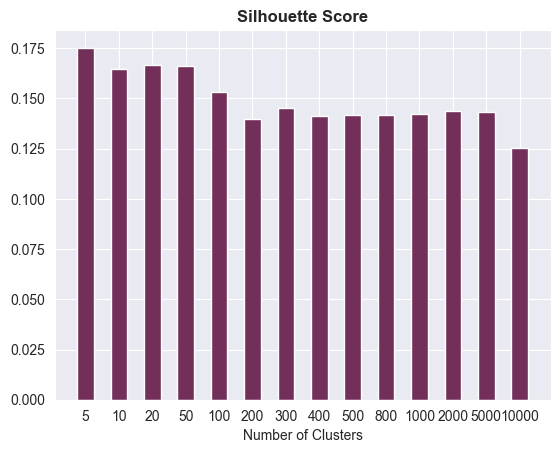

In [12]:
'''
# Silhouette_score
# candidate values for our number of cluster
parameters = [5,10,20,50,100,200,300,400,500,800,1000,2000,5000,10000]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(features_scaled)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(features_scaled, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()
'''

In [14]:
'''
model = pyo.ConcreteModel()
# Set
model.T = pyo.RangeSet(24)
model.E = pyo.RangeSet(len(centroids_df))
# Decision Variable
model.charge_decision = pyo.Var(model.T,model.E, within=pyo.Binary,initialize=0)
# Parameters
model.load_to_match = pyo.Param(model.T, initialize=tomatch['scaled_13_kwh']) 
model.charge_power = pyo.Param(model.T, model.E, initialize=7)
model.arr_hour = pyo.Param(model.E, initialize=centroids_df['arr_hour'])
# Constraints
def arr_hour_too_late_rule(model, t, e):
    return model.charge_decision[t, e] <= (0 if model.arr_hour[e] > t else 1)
model.arr_hour_too_late = pyo.Constraint(model.T, model.E, rule=arr_hour_too_late_rule) # Make sure cars will not charge before arrival hour

# Expressions
def charge_demand_t_rule(model, t):
    return sum(model.charge_decision[t,e] * model.charge_power[t,e] for e in model.E) # Sum up demand at each hour for all EVs
model.charge_demand_t = pyo.Expression(model.T,rule=charge_demand_t_rule)
# Objective 
def objective_rule(model):
    return sum((model.load_to_match[t]-model.charge_demand_t[t])**2 for t in model.T)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

solver = pyo.SolverFactory('gurobi')
solver.solve(model)
for t in model.T:
    for e in model.E:
        print(f'Charge_decision[{t},{e}]:', model.charge_decision[t,e].value)
'''

Charge_decision[1,1]: 0.0
Charge_decision[1,2]: 0.0
Charge_decision[1,3]: 0.0
Charge_decision[1,4]: 0.0
Charge_decision[1,5]: 0.0
Charge_decision[1,6]: 0.0
Charge_decision[1,7]: 0.0
Charge_decision[1,8]: 0.0
Charge_decision[1,9]: 0.0
Charge_decision[1,10]: 0.0
Charge_decision[1,11]: 0.0
Charge_decision[1,12]: 0.0
Charge_decision[1,13]: 0.0
Charge_decision[1,14]: 0.0
Charge_decision[1,15]: 0.0
Charge_decision[1,16]: 0.0
Charge_decision[1,17]: 0.0
Charge_decision[1,18]: 0.0
Charge_decision[1,19]: 0.0
Charge_decision[1,20]: 0.0
Charge_decision[1,21]: 0.0
Charge_decision[1,22]: 0.0
Charge_decision[1,23]: 0.0
Charge_decision[1,24]: 0.0
Charge_decision[1,25]: 0.0
Charge_decision[1,26]: 0.0
Charge_decision[1,27]: 0.0
Charge_decision[1,28]: 0.0
Charge_decision[1,29]: 0.0
Charge_decision[1,30]: 0.0
Charge_decision[1,31]: 0.0
Charge_decision[1,32]: 0.0
Charge_decision[1,33]: 0.0
Charge_decision[1,34]: 0.0
Charge_decision[1,35]: 0.0
Charge_decision[1,36]: 0.0
Charge_decision[1,37]: 0.0
Charge_dec

In [ ]:
'''
#######################################################################################
#            Optimize aggregated demand profile to fit nexus output                   #
#######################################################################################
m = pyo.AbstractModel()
charge_decision_memory = {}

############################
# Set
m.E = pyo.Set() # parking event set

############################
# Decision Variable
m.charge_decision = pyo.Var(m.E, within=pyo.Binary, initialize=0)
#m.charge_power = pyo.Var(m.E, within=pyo.NonNegativeReals, initialize=11)

###########################
# Parameters
m.load_to_match = pyo.Param() 
m.hour_of_day = pyo.Param()
m.max_power = pyo.Param(m.E, initialize=11) # unit kW
m.charge_minutes = pyo.Param(m.E, initialize=0) # parking minutes within this hour
m.distance = pyo.Param(m.E, initialize=0) # distance from parking point to load point
m.arr_hour = pyo.Param(m.E, initialize=0)
m.park_end_hour = pyo.Param(m.E, initialize=0)

def get_charge_status_memory(m,e):
    return charge_decision_memory.get(e,0)
m.previous_charge_decision = pyo.Param(m.E, within=pyo.Binary, mutable=True, initialize=get_charge_status_memory) # charge_decision memory

############################
# Constraints

# def max_power_rule(m,e):
#     return m.charge_power[e]<=m.max_power[e]
# m.max_power_constr = pyo.Constraint(m.E, rule=max_power_rule)


# force charge_decision to 0 when charge_minutes < 10
def no_charge_short_stay_rule(m, e):
    # If charge_minutes for EV 'e' is less than 10, then charge_decision must be 0
    if (m.charge_minutes[e]<15) & ((m.park_end_hour[e]==m.hour_of_day) | (m.arr_hour[e]==m.hour_of_day)):
        return m.charge_decision[e]==0
    else:
        return pyo.Constraint.Skip
m.no_charge_short_stay = pyo.Constraint(m.E, rule=no_charge_short_stay_rule)

def load_point_too_far_rule(m,e):
    if m.distance[e]>30:
        return  m.charge_decision[e]==0
    else:
        return pyo.Constraint.Skip
m.load_point_to_far = pyo.Constraint(m.E, rule=load_point_too_far_rule)

############################
# Expressions

def charge_demand_t_rule(m):
    return sum(m.charge_decision[e] * m.max_power[e] * (m.charge_minutes[e]/60) for e in m.E) # Sum up demand at each hour for all EVs
m.charge_demand_t = pyo.Expression(rule=charge_demand_t_rule)

###########################
# Objective 
def objective_rule(m):
    return ((m.load_to_match-m.charge_demand_t)**2 - sum(m.previous_charge_decision[e]*m.charge_decision[e] for e in m.E))
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)


###########################
# Solve abstract model

for t in range(0,24):
    tomatch_t = tomatch['scaled_12_kwh'][t+1]
    events_t = hourly_df['hour'+str(t)]
    data_t = {None:{
        'E': {None:list(events_t.index)},
        'charge_minutes':{e:events_t.loc[e,'this_hour_parking_time'] for e in events_t.index},
        'arr_hour':{e:events_t.loc[e,'arr_hour'] for e in events_t.index},
        'park_end_hour':{e:events_t.loc[e,'park_end_hour'] for e in events_t.index},
        'distance':{e:events_t.loc[e,'distance'] for e in events_t.index},
        'load_to_match':{None:tomatch_t},
        'hour_of_day':{None:t}
    }}
    instance_t = m.create_instance(data=data_t)
    #instance_t.pprint()
    solver = pyo.SolverFactory('gurobi')
    solver.solve(instance_t)
    
    # update charge_decision_memory dictionary,keep only the memory where the vehicle also include in current hour set
    current_hour_event = set(instance_t.E)
    keys_to_remove = [e for e in charge_decision_memory if e not in current_hour_event]
    for e in keys_to_remove:
        del charge_decision_memory[e]
    for e in current_hour_event:
        charge_decision_memory[e] = instance_t.charge_decision[e].value # assign last charge decision to the memory dictionary

    # save optimization result to csv files
    decision_variables_hour_t={}
    for v in instance_t.component_objects(pyo.Var, active=True):
        print(f"Variable{v}:")
        var_object = getattr(instance_t,str(v))
        for index in var_object:
            variable_value=var_object[index].value
            print(f"  Index {index}: {variable_value}")
            decision_variables_hour_t[(str(v), index)] = variable_value            
    with open(f'version_{version}/decision_variables_hour_{t}_v{version}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Variable Name', 'Index', 'Value'])
        for (var_name, index), value in decision_variables_hour_t.items():
            writer.writerow([var_name, index, value])
'''